![figure 10.3](assets/10.1_figure_10.3.png)

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

ACTIONS = ['forward', 'backward', 'stay']
X_BOUNDS = (-1.2, .6)
VELOCITY_BOUNDS = (-.07, .07)
TERMINAL_X = 0.6
TERMINAL_REWARD = 0
NON_TERMINAL_REWARD = -1
START_X_BOUNDS = (-.6, -0.4)
START_VELOCITY = 0
NUM_TILES = 64
TILING_ROWS_AND_COLS = (8, 8)
TILING_OFFSETS = [
    (0.0, 0.0),
    (1/8, 3/8),
    (2/8, 6/8),
    (3/8, 1/8),
    (4/8, 4/8),
    (5/8, 7/8),
    (6/8, 2/8),
    (7/8, 5/8),
]
NUM_FEATURES = len(TILING_OFFSETS) * NUM_TILES
NUM_ACTION_FEATURES = NUM_FEATURES * len(ACTIONS)

# all inputs are tuples
def get_tile_vector(
    state,
    space_x_range=X_BOUNDS,
    space_y_range=VELOCITY_BOUNDS,
    tile_rows_and_cols=TILING_ROWS_AND_COLS,
    offset=TILING_OFFSETS[0]
):
    rows, cols = tile_rows_and_cols
    num_tiles = rows * cols
    tile_width = (space_x_range[1] - space_x_range[0]) / cols
    tile_height = (space_y_range[1] - space_y_range[0]) / rows

    # offset is fraction of a tile in each dimension (e.g., 0.5 = half-tile shift)
    offset_x_world = offset[0] * tile_width
    offset_y_world = offset[1] * tile_height

    x, y = state
    x_min, _ = space_x_range
    y_min, _ = space_y_range

    col = math.floor((x - x_min + offset_x_world) / tile_width)
    row = math.floor((y - y_min + offset_y_world) / tile_height)

    col = max(0, min(cols - 1, col))
    row = max(0, min(rows - 1, row))

    tile_vector = np.zeros(num_tiles)
    tile_vector[row * cols + col] = 1
    return tile_vector
  
def get_feature_vector(
    state, 
    space_x_range=X_BOUNDS, 
    space_y_range=VELOCITY_BOUNDS, 
    tile_rows_and_cols=TILING_ROWS_AND_COLS, 
    offsets=TILING_OFFSETS
):
    feature_vectors = []
    for i, offset in enumerate(offsets):
        feature_vectors.append(get_tile_vector(state, space_x_range, space_y_range, tile_rows_and_cols, offset))
    return np.concatenate(feature_vectors)

def get_action_feature_vector(state, action):
    state_feature_vector = get_feature_vector(state, X_BOUNDS, VELOCITY_BOUNDS, TILING_ROWS_AND_COLS, TILING_OFFSETS)
    action_feature_vector = np.zeros(NUM_ACTION_FEATURES)
    action_index = ACTIONS.index(action)
    start = action_index * NUM_FEATURES
    end = start + NUM_FEATURES
    action_feature_vector[start:end] = state_feature_vector
    return action_feature_vector

def position_update(x_pos, velocity):
    return max(min(x_pos + velocity, X_BOUNDS[1]), X_BOUNDS[0])

def velocity_update(x_pos, velocity, action ):
    if action == 'forward':
        thrust = 1
    elif action == 'backward':
        thrust = -1
    else:
        thrust = 0
    return max(min(velocity + .001 * thrust - .0025 * math.cos(3 * x_pos), VELOCITY_BOUNDS[1]), VELOCITY_BOUNDS[0])

def update_state(state, action):
    new_velocity = velocity_update(state[0], state[1], action)
    new_x_pos = position_update(state[0], new_velocity)
    if new_x_pos == X_BOUNDS[0]:
        new_velocity = 0
    return (new_x_pos, new_velocity)

def get_reward(state):
    if state[0] >= TERMINAL_X:
        return TERMINAL_REWARD
    else:
        return NON_TERMINAL_REWARD
    
def get_next_state_and_reward(state, action):
    new_state = update_state(state, action)
    reward = get_reward(new_state)
    return new_state, reward

def get_start_state():
    return (np.random.uniform(START_X_BOUNDS[0], START_X_BOUNDS[1]), START_VELOCITY)
    
def get_action_value(state, action, w):
    feature_vector = get_action_feature_vector(state, action)
    return np.dot(w, feature_vector)

def get_action_values(state, w):
    state_feature_vector = get_feature_vector(state, X_BOUNDS, VELOCITY_BOUNDS, TILING_ROWS_AND_COLS, TILING_OFFSETS)
    values = []
    for i in range(len(ACTIONS)):
        start = i * NUM_FEATURES
        end = start + NUM_FEATURES
        w_slice = w[start:end]
        values.append(np.dot(w_slice, state_feature_vector))
    return values

def get_next_action(w, state, epsilon):
    action_values = get_action_values(state, w)
    best_action = ACTIONS[np.argmax(action_values)]
    if np.random.random() < epsilon:
        return np.random.choice(ACTIONS)
    else:
        return best_action

def get_best_action(w, state):
    action_values = get_action_values(state, w)
    return ACTIONS[np.argmax(action_values)]

def generate_episode(w, epsilon):
    episode = []
    state = get_start_state()
    action = get_next_action(w, state, epsilon)
    while state[0] < TERMINAL_X:
        next_state, reward = get_next_state_and_reward(state, action)
        episode.append((state, action, reward))
        state = next_state
        action = get_next_action(w, state, epsilon)
    episode.append((state, None, 0))
    return episode

def train_semi_gradient_n_step_sarsa(alpha, epsilon, gamma, num_episodes, n=1):
    w = np.zeros(NUM_ACTION_FEATURES)
    steps_per_episode = []
    for _ in range(num_episodes):
        episode = []

        current_state = get_start_state()
        current_action = get_next_action(w, current_state, epsilon)

        T = 99999999
        t = 0
        steps = 0
        next_state = None
        next_action = None

        while True:
            if t < T:
                steps += 1
                next_state, reward = get_next_state_and_reward(current_state, current_action)
                episode.append((current_state, current_action, reward))

                if next_state[0] >= TERMINAL_X:
                    T = t + 1
                    steps_per_episode.append(steps)
                else:
                    next_action = get_next_action(w, next_state, epsilon)

            tau = t - n + 1
            if tau >= 0:
                G = 0
                for i in range(tau, min(tau + n, T)):
                    G += (gamma ** (i - tau)) * episode[i][2]
                if tau + n < T:
                    G += (gamma ** n) * get_action_value(next_state, next_action, w)

                s_tau, a_tau, _ = episode[tau]
                w += alpha * (G - get_action_value(s_tau, a_tau, w)) * get_action_feature_vector(s_tau, a_tau)

                if tau == T - 1:
                    break

            t += 1
            current_state = next_state
            current_action = next_action

    return w, steps_per_episode

w, steps_per_episode = train_semi_gradient_n_step_sarsa(alpha=0.5/8, epsilon=0, gamma=1, num_episodes=500)

print(w)
print(steps_per_episode)

episode = generate_episode(w, epsilon=0)
print(len(episode))

[-5.3253203  -8.47674811 -8.13318065 ... -2.70041562 -1.75684586
 -0.54310159]
[2439, 666, 342, 508, 394, 448, 265, 423, 237, 332, 203, 284, 343, 238, 326, 233, 242, 259, 166, 242, 177, 217, 264, 175, 194, 166, 159, 192, 153, 229, 229, 157, 188, 192, 236, 159, 156, 166, 238, 237, 230, 205, 271, 132, 242, 151, 144, 158, 158, 175, 150, 206, 182, 212, 192, 126, 126, 165, 214, 158, 157, 157, 212, 151, 157, 167, 161, 146, 161, 152, 204, 194, 156, 164, 166, 146, 139, 118, 201, 122, 128, 167, 154, 151, 128, 217, 188, 151, 120, 119, 122, 118, 175, 155, 142, 125, 162, 167, 155, 154, 154, 153, 157, 115, 156, 154, 151, 152, 152, 155, 155, 149, 157, 152, 152, 153, 153, 150, 147, 121, 150, 127, 135, 152, 149, 145, 147, 162, 132, 115, 115, 113, 167, 110, 161, 196, 94, 89, 175, 89, 155, 93, 94, 153, 152, 99, 147, 158, 92, 90, 167, 149, 150, 146, 92, 146, 146, 138, 98, 140, 94, 93, 120, 98, 94, 158, 117, 91, 159, 144, 89, 90, 145, 159, 143, 152, 141, 117, 90, 158, 144, 114, 162, 149, 186, 148, 163, 12

In [7]:
def get_avg_steps_per_episode(alpha, epsilon, gamma, num_episodes, n=1):
    steps_per_episodes = []
    for i in range(100):
        w, steps_per_episode = train_semi_gradient_n_step_sarsa(alpha=alpha, epsilon=epsilon, gamma=gamma, num_episodes=num_episodes, n=n)
        steps_per_episodes.append(steps_per_episode)
    return np.mean(steps_per_episodes, axis=0)


avg_steps_per_episode_alpha_1 = get_avg_steps_per_episode(alpha=0.5/8, epsilon=0, gamma=1, num_episodes=500, n=1)
avg_steps_per_episode_alpha_8 = get_avg_steps_per_episode(alpha=0.5/8, epsilon=0, gamma=1, num_episodes=500, n=8)

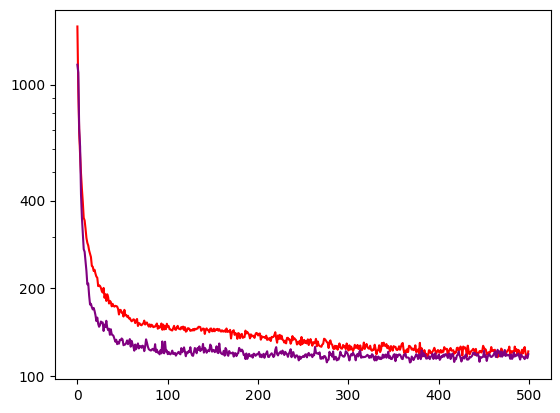

In [8]:
plt.plot(avg_steps_per_episode_alpha_1, color='red', label='n=1')
plt.plot(avg_steps_per_episode_alpha_8, color='purple', label='n=8')
plt.yscale('log')
plt.yticks([100, 200, 400, 1000], ['100', '200', '400', '1000'])
plt.show()